<a href="https://colab.research.google.com/github/ktgiahieu/BinPickingSimulation/blob/master/experiments/p_tuning/P_Tuning_on_GoodBadPapers_Relevance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/Kaggle/kaggle.json .
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/gdrive


In [2]:
!pip install -q git+https://github.com/huggingface/peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.9 MB/s eta 0:00:00


In [3]:
!pip install -q peft datasets evaluate transformers sentencepiece cpm_kernels iterative-stratification==0.1.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.3 MB/s eta 0:00:00


In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
import argparse
import glob
import os
import pandas as pd
import numpy as np

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftConfig,
    PeftModel
)

import evaluate
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

num_workers = 0

In [6]:
BATCH_SIZE = 1
NUM_EPOCHS = 3
MAX_LENGTH = 1500 # SHOULD BE HUGE AND COMBINE WITH INT8 TRAINING IN THE FUTURE
lr = 1e-3
model_name_or_path = "microsoft/deberta-v3-large"
fbprize_peft_model_name_or_path = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
fbprize_base_model_name_or_path = f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
task = "mrpc"
peft_type = PeftType.P_TUNING
device = "cuda"
peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)

In [7]:
bad_papers = []
good_papers = []
for folder_path in sorted(glob.glob('/content/gdrive/MyDrive/UPSaclay/LLMs/good_and_bad_papers/*')):
    if not os.path.isdir(folder_path):
        continue
    with open(os.path.join(folder_path, 'bad_relevance1.txt'), 'r') as f:
        bad_paper = f.read()
    with open(os.path.join(folder_path, 'good_1.txt'), 'r') as f:
        good_paper = f.read()

    bad_papers.append(bad_paper)
    good_papers.append(good_paper)

train = pd.DataFrame({'good': good_papers, 'bad':bad_papers})

In [8]:
train

,good,bad
0,"\n""Art as Information: The Power of Amplified ...","""Art as Information: The Power of Amplified Ar..."
1,\nEnhancing the Ghent Altarpiece: Utilizing Di...,Enhancing the Ghent Altarpiece: Utilizing Digi...
2,\nMaintaining Color Consistency in Artistic Pa...,Maintaining Color Consistency in Artistic Pain...
3,"\n""Rediscovering the Influence of Middle Easte...",Rethinking the Impact of Middle Eastern Archit...
4,"\n""Assessing the Effectiveness of Mitochondria...","""Assessing the Effectiveness of Mitochondrial ..."
...,...,...
113,"\n""Exploring the Potential of Macro-Regional C...","""Exploring the Potential of Macro-Regional Col..."
114,\nAuthor's Bio\n\nWhy It Is Difficult to Teach...,Author's Bio\n\nWhy It Is Difficult to Teach C...
115,"\n""Improving Science Communication Strategies:...","""Improving Science Communication Strategies: T..."
116,"\n""The Impact of Political Affiliation on COVI...","""The Impact of Political Affiliation on COVID ..."


In [9]:
if any(k in model_name_or_path for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
def prepare_input(text):
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=MAX_LENGTH,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, df):
        self.goods = df['good'].values
        self.bads = df['bad'].values

    def __len__(self):
        return len(self.goods)

    def __getitem__(self, item):
        good_inputs = prepare_input(self.goods[item])
        bad_inputs = prepare_input(self.bads[item])
        return good_inputs, bad_inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [11]:
train_folds, valid_folds = train_test_split(train, test_size=0.33, random_state=42)
print(f"Train size: {len(train_folds)}")
print(f"Valid size: {len(valid_folds)}")

train_dataset = TrainDataset(train_folds)
valid_dataset = TrainDataset(valid_folds)

train_dataloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_workers, pin_memory=True, drop_last=True)
eval_dataloader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE * 2,
                          shuffle=False,
                          num_workers=num_workers, pin_memory=True, drop_last=False)

Train size: 79
Valid size: 39


In [12]:
peft_config = PeftConfig.from_pretrained(fbprize_peft_model_name_or_path)
inference_model = AutoModelForSequenceClassification.from_pretrained(fbprize_base_model_name_or_path, return_dict=True, num_labels=6, problem_type = "regression")

tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(inference_model, fbprize_peft_model_name_or_path)
model.print_trainable_parameters()
model

Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.bias', 'classifier.original_module.bias', 'classifier.modules_to_save.default.weight', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize and are newly initi

trainable params: 32780 || all params: 435094540 || trainable%: 0.0075339947957057795


PeftModelForSequenceClassification(
  (base_model): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 1024, padding_idx=0)
        (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-23): 24 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=1024, out_

In [13]:
optimizer = AdamW(params=model.parameters(), lr=lr)

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_dataloader) * NUM_EPOCHS),
    num_training_steps=(len(train_dataloader) * NUM_EPOCHS),
)

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def criterion(outputs1, outputs2, targets):
    return torch.nn.MarginRankingLoss(margin=0.5)(outputs1, outputs2, targets)

In [15]:
model.to(device)
for epoch in range(NUM_EPOCHS):
    
    model.train()
    losses = AverageMeter()
    pbar = tqdm(train_dataloader)
    for step, (goods, bads) in enumerate(pbar):
        goods = collate(goods)
        bads = collate(bads)
        for k, v in goods.items():
            goods[k] = v.to(device)
        for k, v in bads.items():
            bads[k] = v.to(device)

        batch_size = goods['input_ids'].shape[0]

        good_outputs = model(**goods)
        bad_outputs = model(**bads)

        good_overall_scores = good_outputs.logits.sum(-1)
        bad_overall_scores = bad_outputs.logits.sum(-1)

        loss = criterion(good_overall_scores, bad_overall_scores, torch.ones_like(good_overall_scores))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        losses.update(loss.item(), batch_size)
        pbar.set_description(f"Loss: {losses.avg:.2f}")

    model.eval()
    all_good_scores = []
    all_bad_scores = []
    for step, (goods, bads) in enumerate(tqdm(eval_dataloader)):
        goods = collate(goods)
        bads = collate(bads)
        for k, v in goods.items():
            goods[k] = v.to(device)
        for k, v in bads.items():
            bads[k] = v.to(device)

        batch_size = goods['input_ids'].shape[0]

        with torch.no_grad():
            good_outputs = model(**goods)
            bad_outputs = model(**bads)

        good_overall_scores = good_outputs.logits.sum(-1)
        bad_overall_scores = bad_outputs.logits.sum(-1)

        all_good_scores.append(good_overall_scores.cpu().numpy())
        all_bad_scores.append(bad_overall_scores.cpu().numpy())

    all_good_scores = np.concatenate(all_good_scores, axis=0)
    all_bad_scores = np.concatenate(all_bad_scores, axis=0)
    accuracy = np.mean(all_good_scores > all_bad_scores)
    print(f"epoch {epoch} accuracy: {accuracy:.2f}")

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


epoch 0 accuracy: 0.95


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


epoch 1 accuracy: 0.97


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

epoch 2 accuracy: 0.97


## Share adapters on the 🤗 Hub

In [16]:
# model.base_model.push_to_hub(f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-clarity-correct-language", use_auth_token=True)

In [17]:
model.push_to_hub(f"ktgiahieu/{model_name_or_path.split('/')[-1]}-peft-p-tuning-relevance", use_auth_token=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/108k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ktgiahieu/deberta-v3-large-peft-p-tuning-relevance/commit/e6924cbd3a1a094a59d8335fefbb816cb04b28cf', commit_message='Upload model', commit_description='', oid='e6924cbd3a1a094a59d8335fefbb816cb04b28cf', pr_url=None, pr_revision=None, pr_num=None)

## Load adapters from the Hub

You can also directly load adapters from the Hub using the commands below:

In [18]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-peft-p-tuning-relevance"
config = PeftConfig.from_pretrained(peft_model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize", return_dict=True, num_labels=6, problem_type = "regression")

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
inference_model = PeftModel.from_pretrained(inference_model, peft_model_id)
inference_model.to(device)
inference_model.eval()

all_good_scores = []
all_bad_scores = []
for step, (goods, bads) in enumerate(tqdm(eval_dataloader)):
    goods = collate(goods)
    bads = collate(bads)
    for k, v in goods.items():
        goods[k] = v.to(device)
    for k, v in bads.items():
        bads[k] = v.to(device)

    batch_size = goods['input_ids'].shape[0]

    with torch.no_grad():
        good_outputs = inference_model(**goods)
        bad_outputs = inference_model(**bads)

    good_overall_scores = good_outputs.logits.sum(-1)
    bad_overall_scores = bad_outputs.logits.sum(-1)

    all_good_scores.append(good_overall_scores.cpu().numpy())
    all_bad_scores.append(bad_overall_scores.cpu().numpy())

all_good_scores = np.concatenate(all_good_scores, axis=0)
all_bad_scores = np.concatenate(all_bad_scores, axis=0)
accuracy = np.mean(all_good_scores > all_bad_scores)
print()
print(f"accuracy: {accuracy:.2f}")

Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.bias', 'classifier.original_module.bias', 'classifier.modules_to_save.default.weight', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize and are newly initi

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


accuracy: 0.97


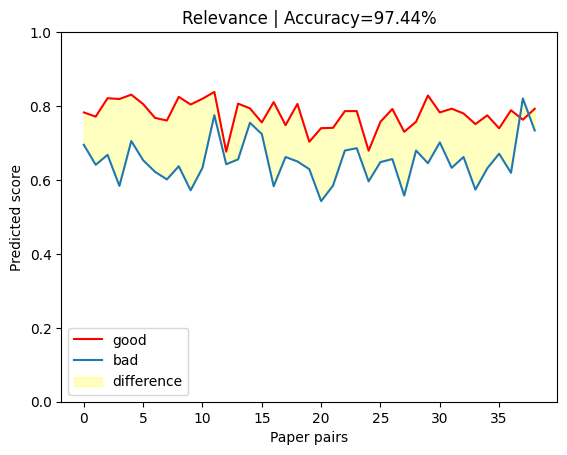

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
good_line = sns.lineplot((all_good_scores-6)/24, label='good', color='red')
bad_line = sns.lineplot((all_bad_scores-6)/24, label='bad')

lines = good_line.get_lines()
plt.fill_between(lines[0].get_xdata(), lines[1].get_ydata(), lines[0].get_ydata(), color='yellow', alpha=.25, label='difference')
plt.legend()
plt.title(f'Relevance | Accuracy={accuracy*100:.2f}%')
plt.xlabel('Paper pairs')
plt.ylabel('Predicted score')
plt.ylim([0,1])
plt.show()